In [ ]:
!pip install rich

In [ ]:
import numpy as np
import pandas as pd
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype, is_categorical_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

In [ ]:
from rich.console import Console
console = Console()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("purumalgi/music-genre-classification")

console.print("Path to dataset files:", path)

100%|██████████| 1.29M/1.29M [00:00<00:00, 1.77MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/purumalgi/music-genre-classification/versions/1

In [ ]:
df_submmission_original = pd.read_csv(f"/{path}/submission.csv",header=0,sep=',')
df_test_data_original = pd.read_csv(f"/{path}/test.csv",header=0,sep=',')
df_train_data_original = pd.read_csv(f"/{path}/train.csv",header=0,sep=',')

console.print("Shape Datasets:")
console.print(df_submmission_original.shape)
console.print(df_test_data_original.shape)
console.print(df_train_data_original.shape)

Shape Datasets:

(7713, 11)

(7713, 16)

(17996, 17)

## **Understanding the dataset**

In [ ]:
df_train_data_original.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


| Nº | Variable | Type | Values / Range | Description |
|---|---|---|---|---|
| 0 | **Popularity** | float64 | 0 – 100 (approx.) | The estimated popularity of the song, often based on plays. |
| 1 | **danceability** | float64 | 0.0 – 1.0 | Measures how suitable a track is for dancing, considering factors like **tempo**, **rhythmic stability**, and **overall regularity**. A higher value means it's easier to dance to. |
| 2 | **energy** | float64 | 0.0 – 1.0 | Reflects the intensity and activity of a track. Energetic songs often sound fast, loud, and noisy. Think death metal (high energy) versus a mellow classical piece (low energy). It considers elements like **dynamic range**, **perceived loudness**, and **timbre**. |
| 3 | **key** | float64 | 0 – 11 | The musical key of the track. Numbers correspond to specific pitches (e.g., 0 = C, 1 = C♯/D♭). A value of -1 means no key was detected. |
| 4 | **loudness** | float64 | Decibels (dB) | The average loudness of a track in decibels (dB). This is useful for comparing how loud different songs are. Typical values range from -60 to 0 dB. |
| 5 | **mode** | int64 | 0 = minor, 1 = major | The mode of the track indicates whether it's in a major (1) or minor (0) key, referring to the type of musical scale used. |
| 6 | **speechiness** | float64 | 0.0 – 1.0 | Quantifies the presence of spoken words. Values above 0.66 suggest mostly spoken word, 0.33-0.66 indicates a mix of music and speech (like rap), and below 0.33 means it's primarily instrumental. |
| 7 | **acousticness** | float64 | 0.0 – 1.0 | A confidence score (from 0.0 to 1.0) indicating how likely a track is to be acoustic. A value of 1.0 means it's highly confident the track is acoustic. |
| 8 | **instrumentalness** | float64 | 0.0 – 1.0 | Predicts whether a track contains vocals. Higher values mean it's more likely to be instrumental. "Ooh" and "aah" sounds are considered instrumental, while rap and spoken word are vocal. |
| 9 | **liveness** | float64 | 0.0 – 1.0 | Estimates if a track was recorded live. Higher values suggest the presence of an audience. |
| 10 | **valence** | float64 | 0.0 – 1.0 | Measures the emotional positivity conveyed by the music. High valence tracks sound happy or euphoric, while low valence tracks sound sad or angry. |
| 11 | **tempo** | float64 | bpm (beats per min) | The estimated tempo of the track in beats per minute (BPM), indicating its speed or pace. |
| 12 | **duration_in min/ms** | float64 | Minutes or milliseconds | The total duration of the song, expressed in milliseconds. |
| 13 | **time_signature** | int64 | 3, 4, 5... | The estimated time signature of the track, which defines how many beats are in each bar (e.g., 4 for 4/4 time). |
| 14 | **Class** | int64 | 0 – 9 | The target Class, representing the music genre as an integer. |

Source: https://developer.spotify.com/documentation/web-api/reference/get-audio-features

In [ ]:
df_train_data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

**Observations:**
- Artist Name and Track Name that are not relevance
- Columns such as Popularity, key, instrumentalness have null values
- Key is the column with more null values
- All samples have at least one class

### **Delete columns that are not relevance**

In [ ]:
df_music = df_train_data_original.copy()

In [ ]:
df_music.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


### Drop unused columns

In [ ]:
df_music.drop(["Artist Name", "Track Name"], axis=1, inplace=True)

### Change the format from seconds to minutes to limit the range

In [ ]:
df_music["duration_in min/ms"] = df_music["duration_in min/ms"] / 1000
df_music.rename(columns={"duration_in min/ms": "duration_in min/sg"}, inplace=True)

In [ ]:
df_music.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/sg,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,200.744459,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,111.989127,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,0.000502,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,166.337000,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,209.160000,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,252.490000,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1477.187000,5.000000,10.000000


**Observations:**
- All columns are numeric
- Columns have multiple ranges, so it is good to apply standardization
- The range of multiple columns is between 0 and 1. ('danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence')
- Mode can be either 0 or 1

In [ ]:
# column names standardization
df_music.columns = df_music.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')
df_music.columns

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_in_min_sg', 'time_signature', 'class'],
      dtype='object')

### **Duplicate Records**

In [ ]:
console.print(f"Number of duplicate records: {df_music.duplicated().sum()}")
df_music.drop_duplicates(inplace=True)
print(f"Number of duplicate records: {df_music.duplicated().sum()}")

Number of duplicate records: 41

Number of duplicate records: 0


## **Univariate analysis**

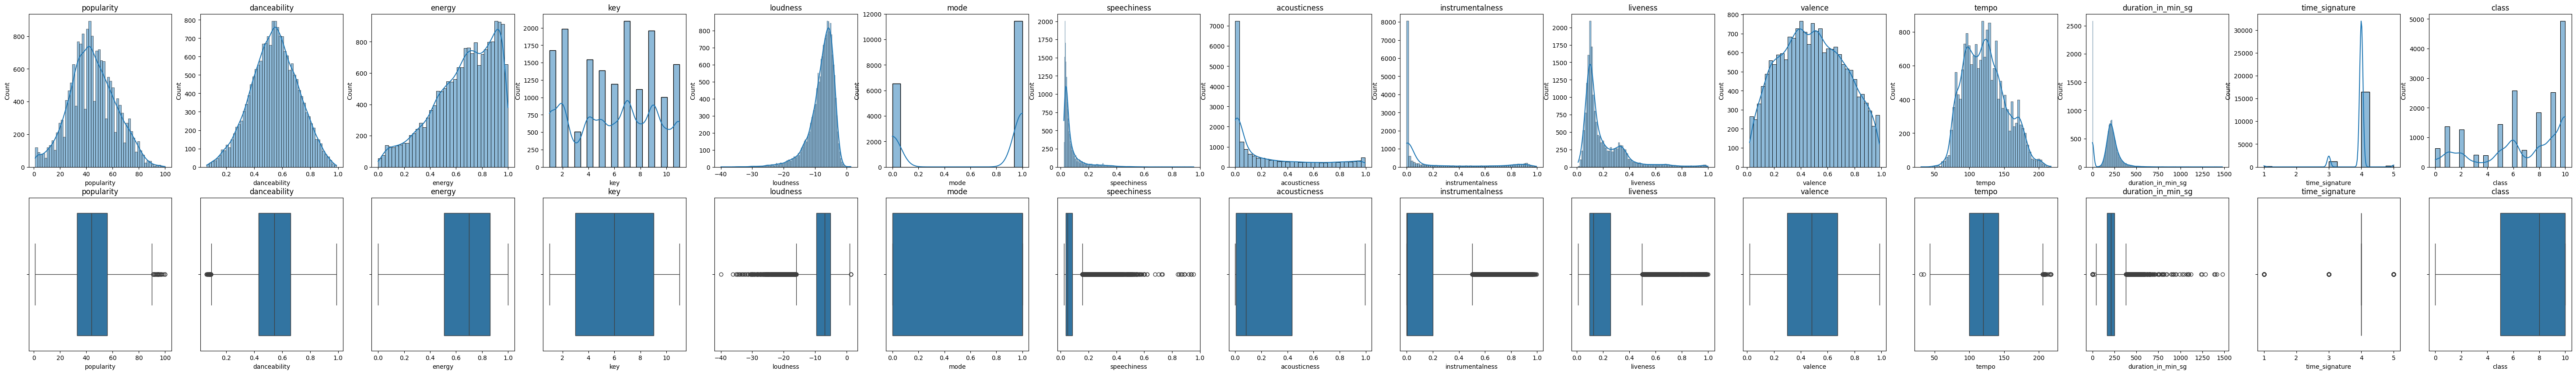

In [ ]:
columns = df_music.columns
fig, ax = plt.subplots(2, len(columns), figsize=(5 * len(columns), 10))
for i, c in enumerate(columns):
  sns.histplot(df_music[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
  sns.boxplot(x=df_music[c], ax=ax[1, i]); ax[1, i].set_title(c)
plt.show()

**Observaciones:**
- Popularity, danceability, valence, and tempo show a normal distribution.
- Energy and loudness are skewed to the left.
- Speech, acoustics, instrumentality, and liveliness are skewed to the right; most values ​​are concentrated in a small data range.
- Key and class are multimodal.
- There are many outliers in each column.

### **Impute Null Values**

In [ ]:
console.print("\nNull values per column:")
console.print(df_music.isnull().sum())

# Fill null values with the mean (good for normally distributed data)
columns_to_fill_mean = ['popularity']
for col in columns_to_fill_mean:
  df_music[col].fillna(df_music[col].mean(), inplace=True)

# Fill null values with the median (good for skewed data and outliers)
columns_to_fill_median = ['instrumentalness']
for col in columns_to_fill_median:
  df_music[col].fillna(df_music[col].median(), inplace=True)

# 'key' if -1 represents no key detected,
df_music['key'].fillna(-1, inplace=True) # If -1 represents no key

console.print("\nNull values after handling:")
console.print(df_music.isnull().sum())

Null values per column:

popularity             428
danceability             0
energy                   0
key                   2010
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4366
liveness                 0
valence                  0
tempo                    0
duration_in_min_sg       0
time_signature           0
class                    0
dtype: int64

<ipython-input-16-4547bc6f3be8>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_music[col].fillna(df_music[col].mean(), inplace=True)
<ipython-input-16-4547bc6f3be8>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

Null values after handling:

popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in_min_sg    0
time_signature        0
class                 0
dtype: int64

### **Remove Outliers**

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

num_cols = [c for c in df_music.columns if is_numeric_dtype(df_music[c])]
for col in df_music.columns:
    df_music = remove_outliers_iqr(df_music, col)

### **Charts after removing outliers**

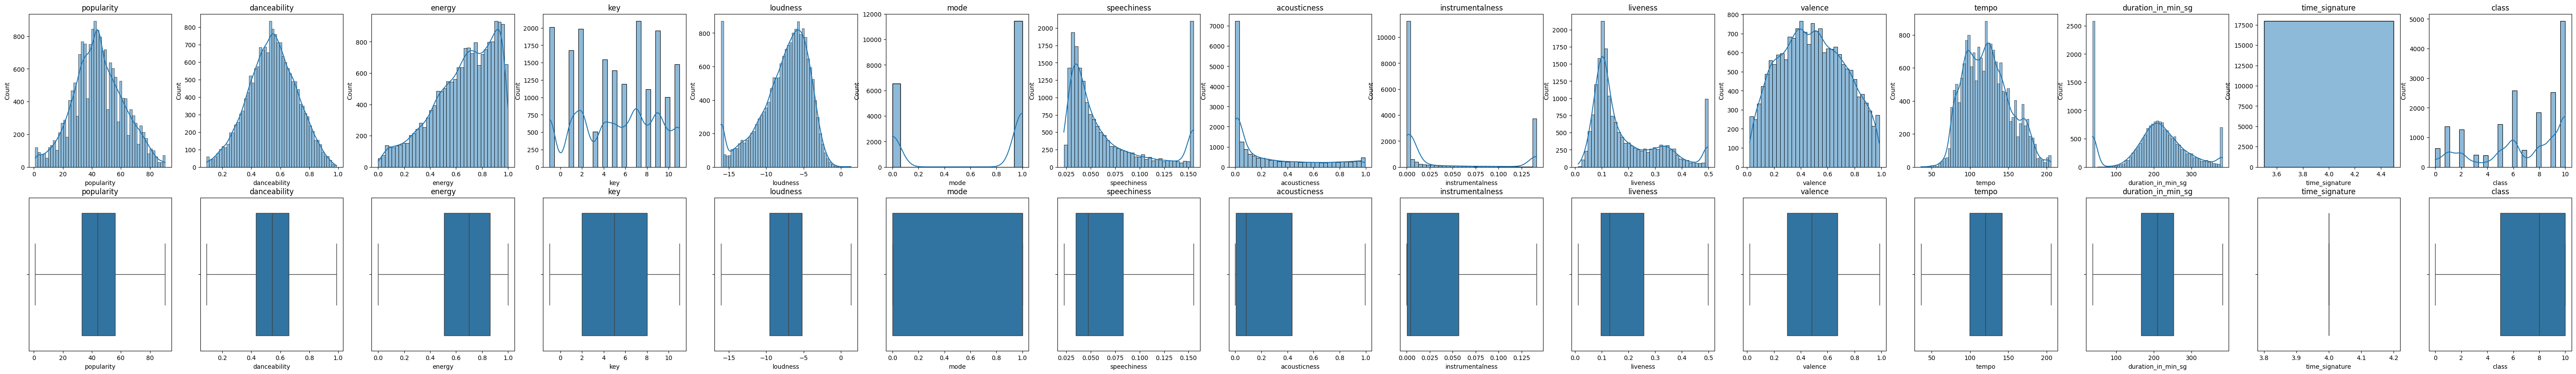

In [ ]:
columns = df_music.columns
fig, ax = plt.subplots(2, len(columns), figsize=(5 * len(columns), 10))
for i, c in enumerate(columns):
  sns.histplot(df_music[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
  sns.boxplot(x=df_music[c], ax=ax[1, i]); ax[1, i].set_title(c)
plt.show()

**Observations:**
- After removing outliers, loudness and duration are more normal
- Time signatue is uniform

Due to the right skew or asymmetry shown in some columns **(speechiness, acousticness, liveness, instrumentalness)** we decided to apply the **logarithm** to transform and found that it looks more like a normal distribution.
We can also apply the **logarithm** to the column **duration** because it has a wide range

In [ ]:
log_cols_transform = ['speechiness', 'acousticness', 'liveness', 'instrumentalness', 'duration_in_min_sg']

for col in log_cols_transform:
    df_music[f'{col}_log'] = np.log1p(df_music[col])

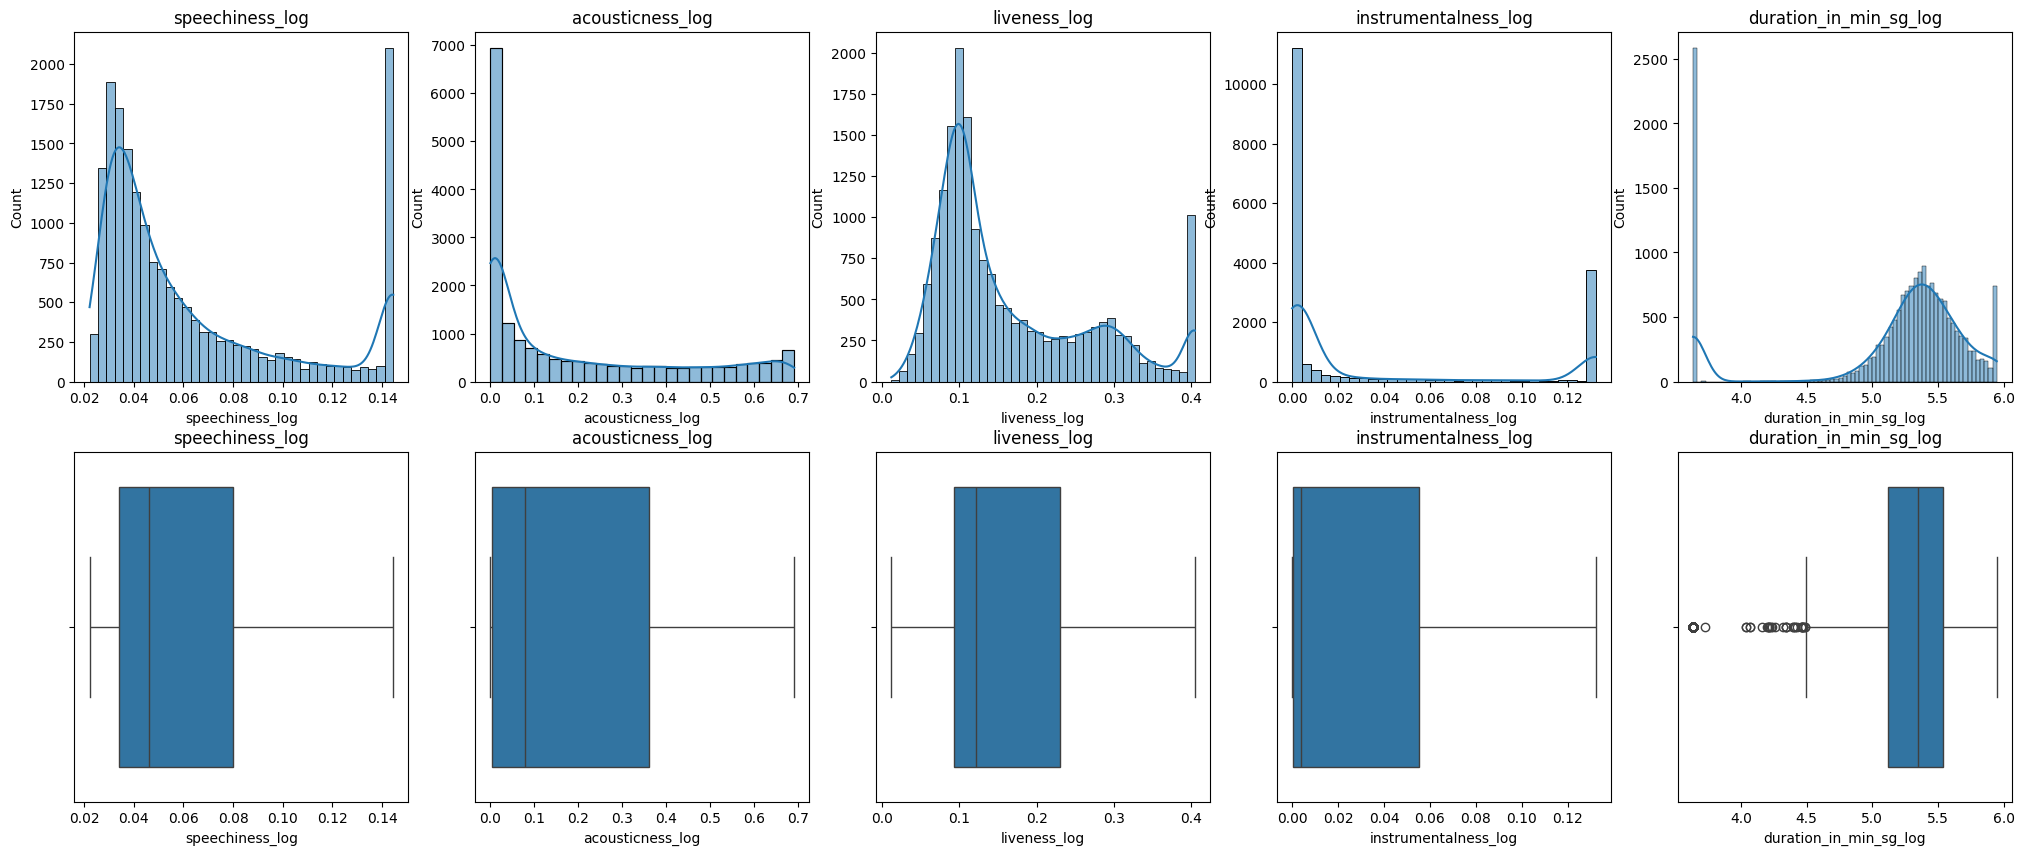

In [ ]:
# Optional: Re-plot histograms and boxplots for transformed columns to check distribution
columns_after_log = log_cols_transform

fig, ax = plt.subplots(2, len(columns_after_log), figsize=(5 * len(columns_after_log), 10))

for i, col in enumerate(columns_after_log):
  sns.histplot(df_music[f'{col}_log'], kde=True, ax=ax[0, i]); ax[0, i].set_title(f'{col}_log')
  sns.boxplot(x=df_music[f'{col}_log'], ax=ax[1, i]); ax[1, i].set_title(f'{col}_log')
plt.show()

In [ ]:
def more_normal(df, col1, col2):
    p1, p2 = shapiro(df_music[col1].dropna())[1], shapiro(df_music[col2].dropna())[1]
    return col1 if p1 > p2 else col2

In [ ]:
log_variables = ['speechiness_log', 'acousticness_log', 'liveness_log', 'instrumentalness_log', 'duration_in_min_sg_log']
zip_variable = list(zip(log_cols_transform, log_variables))

for col1, col2 in zip_variable:
    console.print(f"More Normal: {more_normal(df_music, col1, col2)}")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17955.
  res = hypotest_fun_out(*samples, **kwds)


More Normal: speechiness_log

More Normal: acousticness_log

More Normal: liveness_log

More Normal: instrumentalness_log

More Normal: duration_in_min_sg

The untransformed variable, duration_in_min_ms **exhibit distributions closer to normal than the log-transformed ones**. However, due to range issues, the transformed variables will be retained.

## Class distribution in the dataset (balance)

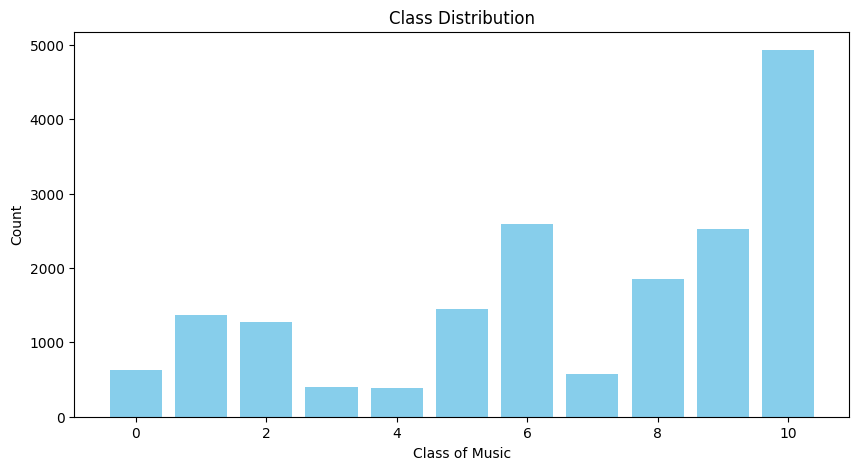

In [ ]:
class_ = df_music.groupby('class').size()
labels = class_.index.values
sizes = class_.values

plt.figure(figsize=(10, 5))
plt.bar(labels, sizes, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class of Music')
plt.ylabel('Count')
plt.show()

**Observations:**
- We can observe **imbalanced data**
- If a machine learning model is trained on **imbalanced data**, it tends to be biased toward the majority class. This means it may misclassify most examples in the minority class, as it has few examples from which to "learn" its patterns. This results in poor model performance when detecting the most critical or "rare" cases.

## **Feature Engineering**

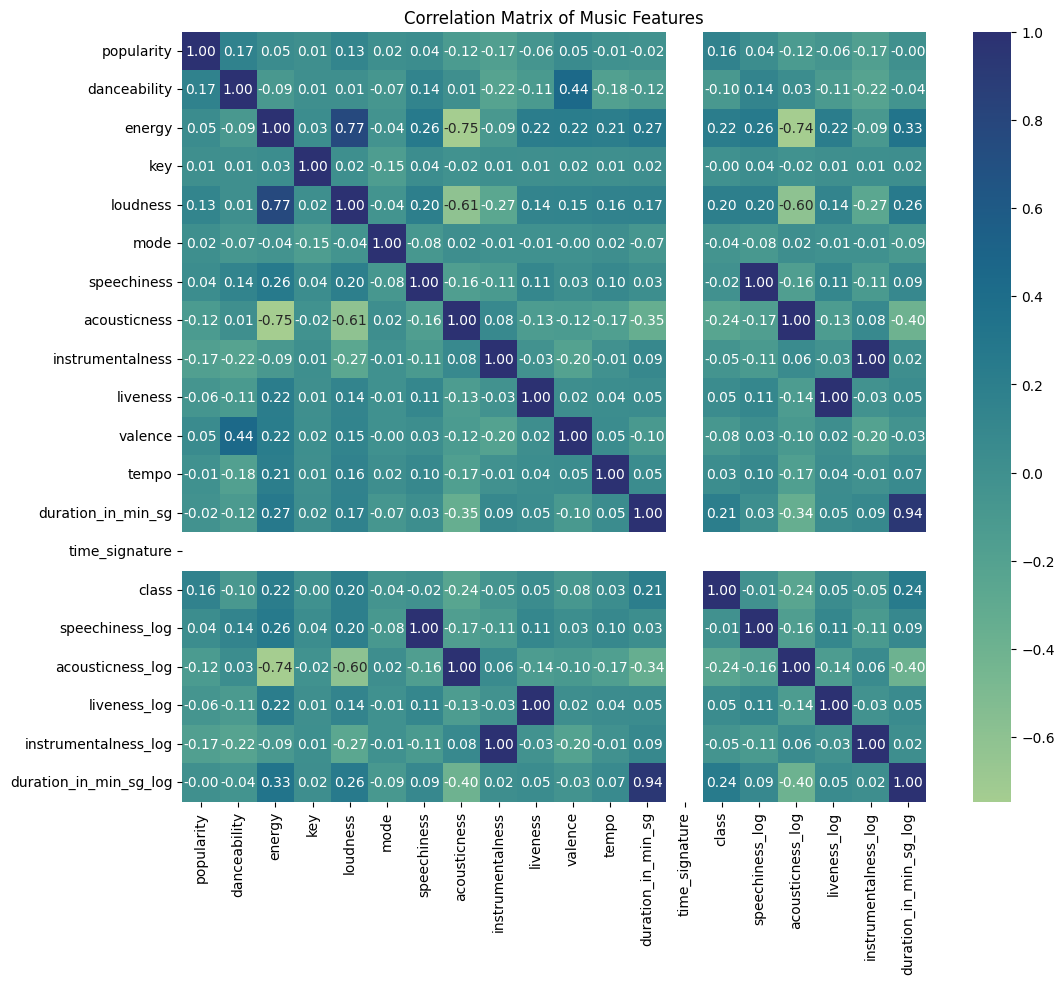

In [ ]:
correlation_matrix = df_music.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix of Music Features')
plt.show()

**Useful Features for Prediction**

- Duration (raw and log) is positively correlated with class, suggesting longer (or logarithmically transformed) track durations are associated with one of the classes.

- Instrumentalness (both raw and log) is also a good predictor — instrumental tracks might be more likely to belong to a particular class.

- Speechiness_log shows a moderate correlation and may be beneficial for some class distinctions.



In [ ]:
df_music.drop(log_cols_transform, axis=1, inplace=True)
df_music.head()

,popularity,danceability,energy,key,loudness,mode,valence,tempo,time_signature,class,speechiness_log,acousticness_log,liveness_log,instrumentalness_log,duration_in_min_sg_log
0,60.0,0.854,0.564,1.0,-4.964,1,0.8990,134.071,4,5,0.047361,0.016955,0.081488,0.003912,5.462118
1,54.0,0.382,0.814,3.0,-7.230,1,0.5690,116.454,4,10,0.039797,0.001099,0.096219,0.004002,5.532334
2,35.0,0.434,0.614,6.0,-8.334,1,0.7870,147.681,4,6,0.051168,0.396088,0.332177,0.000196,4.706526
3,66.0,0.853,0.597,10.0,-6.528,0,0.5690,107.033,4,5,0.054015,0.020978,0.115113,0.003912,5.164603
4,53.0,0.167,0.975,2.0,-4.279,1,0.0918,199.060,4,10,0.144468,0.000169,0.158712,0.015972,5.442245


### **Zero Variance**

In [ ]:
df_music.nunique()

,0
popularity,92
danceability,880
energy,1208
key,12
loudness,8243
mode,2
valence,1320
tempo,13532
time_signature,1
class,11


In [ ]:
columns_removed = df_music.columns[df_music.nunique() == 1].tolist()
print("Columnas removing for variance:", columns_removed)
df_music = df_music.loc[:, df_music.nunique() > 1]

Columnas removing for variance: ['time_signature']


### **High collinearity**

In [ ]:
upper_tri = df_music.corr().where(np.triu(np.ones(df_music.corr().shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.60)]
df_music = df_music.drop(columns=to_drop)
print("columns removing for high collinearity:", to_drop)

columns removing for high collinearity: ['loudness']


## **Featured Selected**

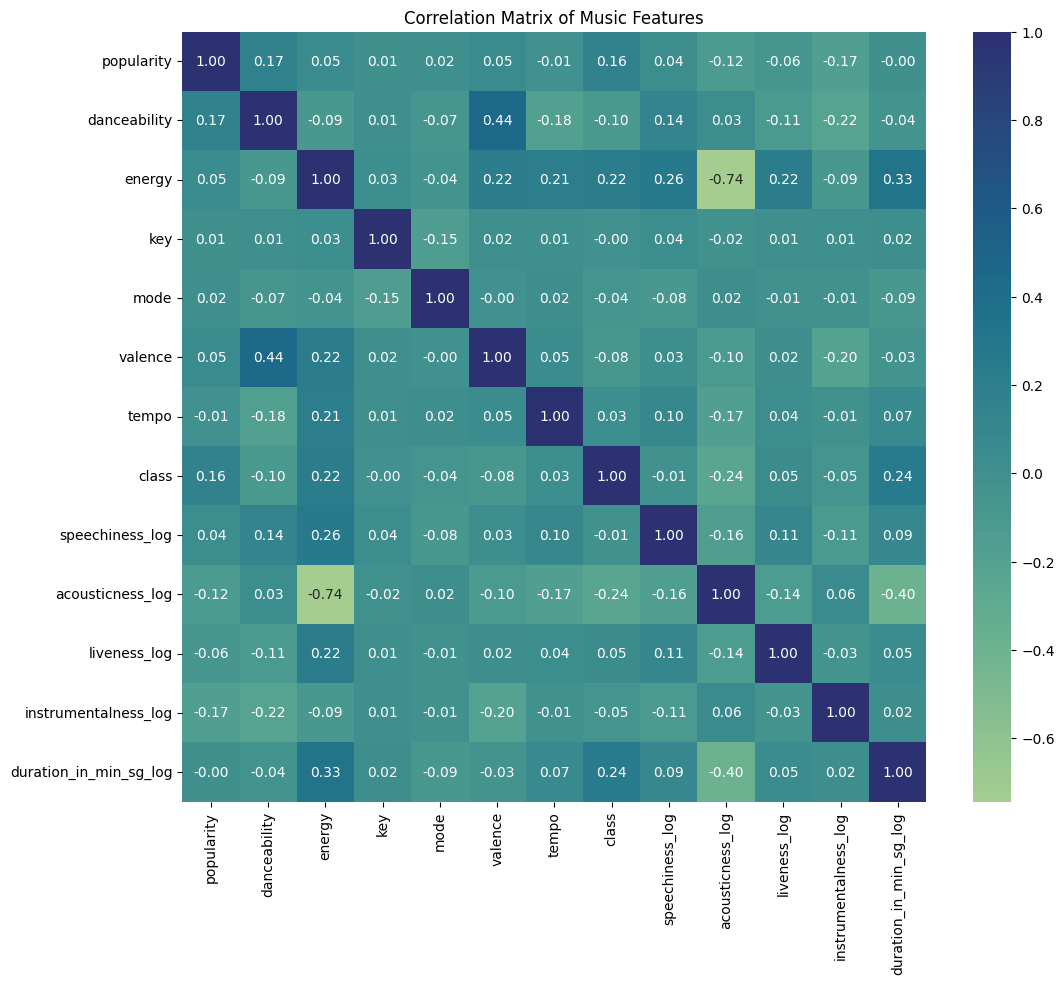

In [ ]:
correlation_matrix = df_music.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix of Music Features')
plt.show()

We believe to start with the top 6 features **popularity, energy,speechiness_log, acousticness_log, instrumentalness_log, duration_in_min_ms_log**

In [ ]:
df_music.columns

Index(['popularity', 'danceability', 'energy', 'key', 'mode', 'valence',
       'tempo', 'class', 'speechiness_log', 'acousticness_log', 'liveness_log',
       'instrumentalness_log', 'duration_in_min_sg_log'],
      dtype='object')

In [ ]:
df_music.drop(['energy', 'key', 'tempo'], axis=1, inplace=True)

In [ ]:
df_music.columns

Index(['popularity', 'danceability', 'mode', 'valence', 'class',
       'speechiness_log', 'acousticness_log', 'liveness_log',
       'instrumentalness_log', 'duration_in_min_sg_log'],
      dtype='object')

In [ ]:
df_music.to_csv('processed_music_data.csv', index=False)

**Here's a summary of what we've done and why:**

- **Data Loading and Initial Inspection:** We loaded the training data and performed an initial inspection using df_train_data_original.head() and df_train_data_original.info(). This helped identify irrelevant columns and columns with missing values.
- **Handling Irrelevant Columns:** Based on the observation that 'Artist Name' and 'Track Name' are not relevant for genre classification, We dropped these columns using df_music.drop(["Artist Name", "Track Name"], axis=1, inplace=True).
- **Duration Unit Conversion:** The 'duration_in min/ms' column had values in milliseconds, which had a very wide range. We converted these to seconds by dividing by 1000 and renamed the column to 'duration_in min/sg' for better interpretability.
- **Handling Duplicate Records:** We checked for and removed duplicate rows using df_music.duplicated().sum() and df_music.drop_duplicates(inplace=True).
- **Univariate Analysis and Outlier Treatment:** We visualized the distribution of each feature using histograms and boxplots to understand their distributions and identify outliers. We then applied the IQR method to clip outliers in all numeric columns to the upper and lower bounds calculated from the first and third quartiles.
- **Log Transformation:** For columns with skewed distributions ('speechiness', 'acousticness', 'liveness', 'instrumentalness', 'duration_in min/sg'), We applied a log transformation (np.log1p) to make their distributions more normal-like, as this can improve the performance of some models.
- **Zero Variance Feature Removal:** We identified and removed the 'time_signature' column because it had only one unique value, meaning it wouldn't contribute any useful information for classification.
- **High Collinearity Feature Removal:** We calculated the correlation matrix and removed the 'loudness' column because it had a high correlation (greater than 0.60) with 'energy'. Removing one of these highly correlated features helps to avoid multicollinearity issues in the model.
- **Feature Selection:** Based on the correlation analysis and the goal of starting with a manageable set of features, We dropped 'energy', 'key', and 'tempo'.

These steps were taken to clean the data, handle missing values and outliers, transform skewed features, and select a set of features that are likely to be most informative for music genre classification.